In [100]:
from TCSPC import *

In [101]:
EGFP = Simulation([0.497,0.503],[2.43,3.07])

In [102]:
# tdata = np.loadtxt('EGFPt.csv')
# ydata = np.loadtxt('EGFPy2.csv')

In [103]:
def trim_rescale_data(tdata,ydata,end =int(0.6*380),rescale = True):
    max_idx = np.argmax(ydata) #index of data point with maximum photon count N(0)
    tdata = tdata[:end-max_idx] #start from t = 0
    ydata = ydata[max_idx:end]  #start from max.
    if rescale == True:
        yerr = ydata/ydata[0]*np.sqrt(1/ydata+1/ydata[0]) #error after scaling
        ydata = ydata/ydata[0] # scale y data such that the beginning is 1 
    else:
        yerr = np.sqrt(ydata)
    weights = 1/yerr #weighted by 1/yerr, yerr is error after scaling ydata
    return tdata,ydata,weights

In [104]:
def trim_rescale_data(tdata,ydata,r = 0.1,end =int(0.6*380),rescale = True):
    '''Trim and rescale data (if rescale ==True)
       tdata    EGFP.t
       ydata    EGFP.y2 
       r        select points with y>r*max(y)
       rescale  True to rescale, False won't rescale'''
     #select points >r* max ydata only
    ydata = ydata[ydata>r*np.max(ydata)]
    #trim away IRF
    ydata = ydata[np.argmax(ydata):]
    #set tdata to same length, start from t = 0
    tdata = tdata[:len(ydata)]
    if rescale == True:
        yerr = ydata/ydata[0]*np.sqrt(1/ydata+1/ydata[0]) #error after scaling
        ydata = ydata/ydata[0] # scale y data such that the beginning is 1 
    else:
        yerr = np.sqrt(ydata)
    weights = 1/yerr #weighted by 1/yerr, yerr is error after scaling ydata
    return tdata,ydata,weights

In [105]:
def exp(t, A, tau):
    return A * np.exp(-t/tau)

In [106]:
np.argmax(ydata)

0

In [107]:
tdata,ydata,weights = trim_rescale_data(EGFP.t,EGFP.y2)
len(tdata)

120

In [108]:
def poisson_deviance_residual(observed, expected):
    residual=  np.sqrt(abs(2 *  (observed* np.log(observed/ expected) - (observed- expected)))) #residual array
    return residual

def residual(p, t, data):
    v = p.valuesdict()
    expected = 0
    if 'c' in v:
        expected = v['c'] #constant background
    M = 1
    while f'A{M}' in v:
        expected += exp(t, v[f'A{M}'], v[f'tau{M}']) #add exponential component
        M += 1
    if 'A0' in v:
        expected *= v['A0'] #overall scaling factor if data is not rescaled
    return poisson_deviance_residual(data, expected) #lmfit.minimizer minimize the residual array in the sum of squared sense


In [109]:
def initial_params(M,A_guess,tau_guess,c_guess = 0,rescale = True,bg_removed = False):
    p = lmfit.Parameters()
    if bg_removed == False:
        p.add_many(('c', c_guess, True, 0)) #constant background
    if rescale == False:
        for i in range(M+1): #for each component
            p.add_many((f'A{i}', A_guess[i], True,0)) #amplitude
    else: 
        for i in range(1,M+1): #for each component
            p.add_many((f'A{i}', A_guess[i-1], True,0)) #amplitude
    for i in range(1,M+1):
        p.add_many((f'tau{i}', tau_guess[i-1], True, 0)) #lifetime
    p[f'A{M}'].set(expr = f'1 {"".join([f"- A{i}" for i in range(1,M)])}') #fix the amplitude of last component
    return p



In [110]:
def initial_params(M,A_guess,tau_guess,c_guess = 0,rescale = True,bg_removed = False):
    p = lmfit.Parameters()
    if bg_removed == False:
        p.add_many(('c', c_guess, True, 0)) #constant background
    for i in range(1,M+1): #for each component
        p.add_many((f'A{i}', A_guess[i-1], True,0)) #amplitude
    for i in range(1,M+1):
        p.add_many((f'tau{i}', tau_guess[i-1], True, 0)) #lifetime
    if rescale == True:
        p[f'A{M}'].set(expr = f'1 {"".join([f"- A{i}" for i in range(1,M)])}') #fix the amplitude of last component
    return p

In [111]:
import numdifftools as nd

In [112]:
def chi2(params):
    M = int((len(params)-1)/2)
    p = initial_params(M,params[1:M+1],params[M+1:],c_guess=params[0],rescale = False)
    return np.dot(residual(p, tdata, ydata),residual(p, tdata, ydata))

In [113]:
mi1.params

name,value,initial value,min,max,vary
c,0.42032426,0,0.00000000,inf,True
A1,76.2243939,88.69,0.00000000,inf,True
A2,91.6513806,92.31,0.00000000,inf,True
A3,13.9290900,1,0.00000000,inf,True
tau1,2.45113424,2.43,0.00000000,inf,True
tau2,3.08758426,3.07,0.00000000,inf,True
tau3,0.03903894,1,0.00000000,inf,True


In [114]:
[v.value for v in mi1.params.values()]

[0.42032425728305833,
 76.22439389852553,
 91.6513805814611,
 13.929090038185768,
 2.4511342418999997,
 3.087584261871327,
 0.03903894203174407]

In [115]:
nd.Gradient(chi2)([v.value for v in mi1.params.values()])

array([ 238.61466654,   86.30542909,  102.24491137,    2.68325011,
       2088.86220206, 2090.52562902,  451.71337701])

In [116]:
H = nd.Hessian(chi2)([v.value for v in mi1.params.values()])
np.diag(np.linalg.inv(H))

array([ 3.33465826e+01,  7.87213572e-01,  1.16189899e+00, -3.25350834e+00,
       -1.47318834e-06, -2.08470723e-06, -6.17453298e-08])

### bi-exp decay fit to EGFP

In [117]:
EGFP.n_photon = int(1e5)
EGFP.multi_exp_data()
tdata,ydata,weights = trim_rescale_data(EGFP.t,EGFP.y2-EGFP.bg*EGFP.run_time/380,r = 0.2,end = int(0.5*380))
p1 = initial_params(2,EGFP.amp,EGFP.tau)
p1['c'].set(value = 0, vary = False)
mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method='powell')

print(lmfit.fit_report(mi1))


[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 300
    # data points      = 85
    # variables        = 3
    chi-square         = 0.03394922
    reduced chi-square = 4.1401e-04
    Akaike info crit   = -659.170950
    Bayesian info crit = -651.842996
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c:     0 (fixed)
    A1:    0.55186243 (init = 0.497)
    A2:    0.44813757 == '1 - A1'
    tau1:  2.13480823 (init = 2.43)
    tau2:  3.62452023 (init = 3.07)


In [118]:
tdata

array([0.        , 0.05277045, 0.1055409 , 0.15831135, 0.21108179,
       0.26385224, 0.31662269, 0.36939314, 0.42216359, 0.47493404,
       0.52770449, 0.58047493, 0.63324538, 0.68601583, 0.73878628,
       0.79155673, 0.84432718, 0.89709763, 0.94986807, 1.00263852,
       1.05540897, 1.10817942, 1.16094987, 1.21372032, 1.26649077,
       1.31926121, 1.37203166, 1.42480211, 1.47757256, 1.53034301,
       1.58311346, 1.63588391, 1.68865435, 1.7414248 , 1.79419525,
       1.8469657 , 1.89973615, 1.9525066 , 2.00527704, 2.05804749,
       2.11081794, 2.16358839, 2.21635884, 2.26912929, 2.32189974,
       2.37467018, 2.42744063, 2.48021108, 2.53298153, 2.58575198,
       2.63852243, 2.69129288, 2.74406332, 2.79683377, 2.84960422,
       2.90237467, 2.95514512, 3.00791557, 3.06068602, 3.11345646,
       3.16622691, 3.21899736, 3.27176781, 3.32453826, 3.37730871,
       3.43007916, 3.4828496 , 3.53562005, 3.5883905 , 3.64116095,
       3.6939314 , 3.74670185, 3.7994723 , 3.85224274, 3.90501

In [119]:
result = mi1
del result.params['A2']

In [120]:
info_df,par_df = fit_df([result])

AttributeError: 'NoneType' object has no attribute 'items'

In [121]:
par_df

NameError: name 'par_df' is not defined

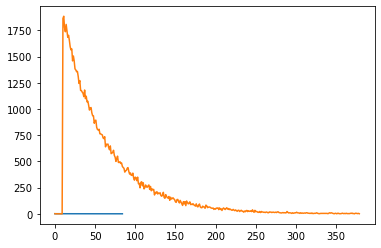

In [122]:
y = EGFP.y2-EGFP.bg*EGFP.run_time/EGFP.n_bins
plt.plot(ydata)
plt.plot(EGFP.y2-EGFP.bg*EGFP.run_time/EGFP.n_bins)

### No rescale

In [123]:
EGFP.n_photon = int(1e4)
EGFP.multi_exp_data()
y_no_bg = EGFP.y2-EGFP.bg*EGFP.run_time/EGFP.n_bins
y_with_bg = EGFP.y2
tdata,ydata,weights = trim_rescale_data(EGFP.t,y_no_bg,end = 200,rescale = False) #bg removed
p1 = initial_params(2,np.max(EGFP.y2)*EGFP.amp,EGFP.tau,rescale = False)
p1['c'].set(value = 0, vary = False)
mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata),method = 'powell')

print(lmfit.fit_report(mi1))



[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 430
    # data points      = 117
    # variables        = 4
    chi-square         = 98.2397105
    reduced chi-square = 0.86937797
    Akaike info crit   = -12.4473198
    Bayesian info crit = -1.39862409
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c:     0 (fixed)
    A1:    100.124015 (init = 96.418)
    A2:    88.6286339 (init = 97.582)
    tau1:  2.01620196 (init = 2.43)
    tau2:  3.69126049 (init = 3.07)


### mono-exp decay fit to EGFP

In [124]:
p1

name,value,initial value,min,max,vary
c,0.00000000,0,0.00000000,inf,False
A1,96.4180000,96.418,0.00000000,inf,True
A2,97.5820000,97.582,0.00000000,inf,True
tau1,2.43000000,2.43,0.00000000,inf,True
tau2,3.07000000,3.07,0.00000000,inf,True


In [125]:
EGFP.n_photon = int(1e4)
EGFP.multi_exp_data()
tdata,ydata,weights = trim_rescale_data(EGFP.t,EGFP.y2,end = 100,rescale = False)
p1 = initial_params(3,[np.max(EGFP.y2*0.49),np.max(EGFP.y2)*0.51,1],EGFP.tau+[1],rescale = False)
#p1['c'].set(value = 0, vary = False)
mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata),method = 'powell')

print(lmfit.fit_report(mi1))

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 651
    # data points      = 113
    # variables        = 7
    chi-square         = 81.2025601
    reduced chi-square = 0.76606189
    Akaike info crit   = -23.3398380
    Bayesian info crit = -4.24812324
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c:     2.62612210 (init = 0)
    A1:    71.3017289 (init = 99.47)
    A2:    101.792406 (init = 103.53)
    A3:    27.3155460 (init = 1)
    tau1:  2.05897616 (init = 2.43)
    tau2:  3.18267957 (init = 3.07)
    tau3:  8.0881e-05 (init = 1)


In [126]:
np.sum(residual(mi1.params,tdata,ydata))

75.46105262708585

## Get 100 simulation at each point (bi-exp decay)


In [144]:
def MLEfit(N,tdata,ydata,method ='powell',end=100,rescale=False):

    tdata, ydata, weights = trim_rescale_data(tdata,ydata, end=end, rescale=rescale)
    p1 = initial_params(N, [np.max(ydata * 0.49), np.max(ydata) * 0.51], EGFP.tau, rescale=rescale)
    mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method=method)
    par_dict = {k:[v.value] for k,v in mi1.params.items()} #turn params values into dict
    A_sum = sum([par_dict[f'A{j}'][0] for j in range(1,N+1)]) #sum all An
    for i in range(1,N+1):
      par_dict[f'A{i}'][0]=par_dict[f'A{i}'][0]/A_sum

    return pd.DataFrame.from_dict(par_dict)
MLEfit(2,EGFP.t,EGFP.sim_data[2])

,c,A1,A2,tau1,tau2
0,7126.100187,0.490065,0.509935,2.422145,3.071184


In [128]:
def MLEfit(N,tdata,ydata,method ='powell',end=100,rescale=False):

    tdata, ydata, weights = trim_rescale_data(tdata,ydata, end=end, rescale=rescale)
    p1 = initial_params(N, [np.max(ydata * 0.49), np.max(ydata) * 0.51], EGFP.tau, rescale=rescale)
    mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method=method)
    par_dict = {k:[v.value] for k,v in mi1.params.items()} #turn params values into dict
    A_sum = sum([par_dict[f'A{j}'][0] for j in range(1,N+1)]) #sum all An
    for i in range(1,N+1):
      par_dict[f'A{i}'][0]=par_dict[f'A{i}'][0]/A_sum

    return pd.DataFrame.from_dict(par_dict)

def val_df():
  '''Create dataframe of fitted parameters'''
  df_list = []
  for j in range(100):
    df_list.append( MLEfit(N,EGFP.t,EGFP.sim_data[j]))
    df= pd.concat(df_list).reset_index()
  return df.drop(['index'],axis =1)

N=2 #components
EGFP.y_list = np.zeros((20,100,380))
n_photon_arr = np.logspace(4,9,20)
df_list = []
for i in range(len(n_photon_arr)):
  EGFP.n_photon = n_photon_arr[i]
  EGFP.repeat_sim(100)
  EGFP.y_list[i] = EGFP.sim_data
  df =val_df()
  df_list.append(df)


In [129]:
df = val_df()

In [130]:
n_val_df =pd.concat(df_list,keys = range(20))

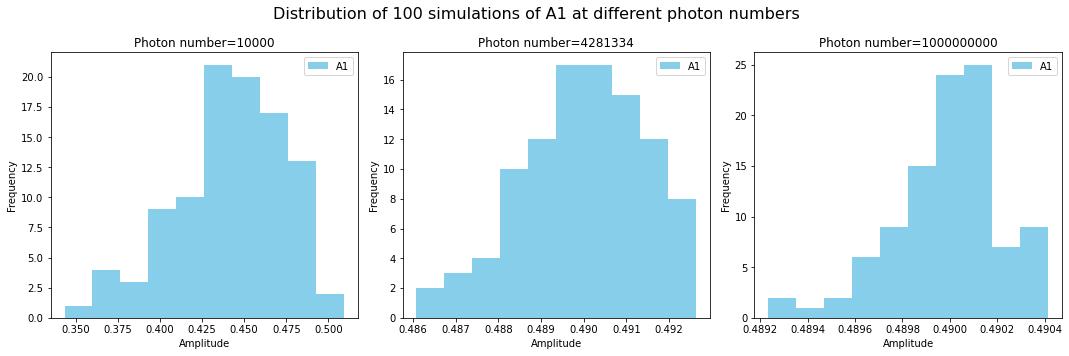

In [131]:
# Setup for loop parameters
indices = [0, 10, 19]  # Indices for low, middle, high photon number
titles = ['Photon number=10000', 'Photon number=4281334', 'Photon number=1000000000']
colors = ['skyblue', 'skyblue', 'skyblue']  # Using the same color, but allows customization
bins = 10  # Assuming you want the same number of bins for each histogram

# Set up the subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

for i, (index, title) in enumerate(zip(indices, titles)):
    axs[i].hist(n_val_df.loc[index, 'A1'], bins=bins, color=colors[i])
    axs[i].set_xlabel('Amplitude')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(title)
    axs[i].legend(['A1'])

# Add a main title for the plots
fig.suptitle('Distribution of 100 simulations of A1 at different photon numbers', fontsize=16)

# Adjust layout to prevent overlapping
plt.subplots_adjust(top=0.85)

plt.tight_layout()
plt.show()


In [132]:
mean_df = n_val_df.groupby(level=0).mean()
std_df = n_val_df.groupby(level=0).std()

In [133]:
mean_df

,c,A1,A2,tau1,tau2
0,3.641905,0.443062,0.556938,2.216590,2.945727
1,3.915720,0.461171,0.538829,2.276544,3.016053
2,4.921230,0.472944,0.527056,2.349057,3.016474
3,5.013423,0.476350,0.523650,2.386580,3.035590
4,6.675422,0.483971,0.516029,2.421343,3.033608
5,9.109749,0.486158,0.513842,2.419881,3.041040
6,11.966228,0.487054,0.512946,2.431600,3.041213
7,21.796761,0.487990,0.512010,2.425616,3.049218
8,26.398535,0.487875,0.512125,2.435953,3.045959
9,35.141721,0.489592,0.510408,2.422731,3.063324


In [134]:
std_df

,c,A1,A2,tau1,tau2
0,2.502655,0.032864,0.032864,0.255493,0.132079
1,3.458502,0.021024,0.021024,0.176653,0.091799
2,4.557508,0.017388,0.017388,0.109603,0.076994
3,5.400703,0.013147,0.013147,0.132359,0.076419
4,6.475979,0.010426,0.010426,0.103684,0.082494
5,9.231790,0.008932,0.008932,0.080742,0.072381
6,13.769405,0.007479,0.007479,0.080775,0.078008
7,21.451255,0.006287,0.006287,0.061379,0.058835
8,25.461123,0.005932,0.005932,0.057422,0.055833
9,32.808203,0.002651,0.002651,0.027804,0.024287


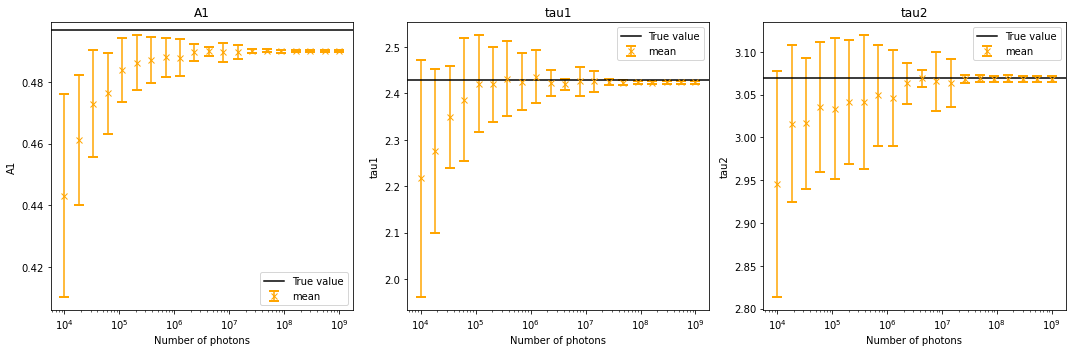

In [135]:
# Set up the subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
true = [0.497,2.43,3.07]
# A1 plot
for i in range(3):
    col = ['A1','tau1','tau2'][i] #column name
    axs[i].errorbar(n_photon_arr, mean_df[col], yerr=std_df[col], fmt='x', ecolor='orange', capthick=2,
                    capsize=5, color='orange', label='mean')
    axs[i].axhline(y=true[i], color='k', linestyle='-', label='True value')
    axs[i].set_xscale('log')
    axs[i].set_xlabel('Number of photons')
    axs[i].set_ylabel(col)
    axs[i].set_title(col)
    axs[i].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


In [136]:
par_dict = {k:v.value for k,v in mi1.params.items()}
A_sum = sum([par_dict[f'A{j}'] for j in range(1,N+1)])
for i in range(1,N+1):
  par_dict[f'A{i}']=par_dict[f'A{i}']/A_sum

In [141]:
par_dict

{'c': 2.6261220976405935,
 'A1': 0.4119245809129398,
 'A2': 0.5880754190870602,
 'A3': 27.31554596339662,
 'tau1': 2.0589761595478713,
 'tau2': 3.1826795650414406,
 'tau3': 8.088133811301468e-05}

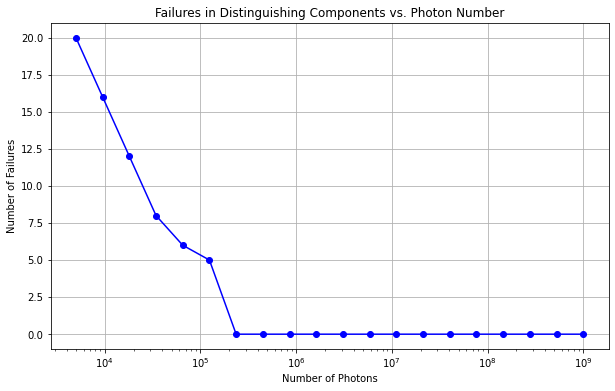

In [153]:
# Reset failure_counts to ensure clean start
failure_counts = []

# Assuming n_photon_arr is defined and correctly populated
for n_photon in n_photon_arr:
    failures = 0
    for j in range(100):  # For each simulation
        EGFP.n_photon = n_photon
        EGFP.repeat_sim(100)
        # Assuming the simulation data EGFP.sim_data[j] is correctly populated
        # and MLEfit function works as expected
        fit_results_df = MLEfit(2, EGFP.t, EGFP.sim_data[j], method='powell', end=100, rescale=False)
        
        # Extract fitted values
        A1 = fit_results_df['A1'].iloc[0]
        A2 = fit_results_df['A2'].iloc[0]
        tau1 = fit_results_df['tau1'].iloc[0]
        tau2 = fit_results_df['tau2'].iloc[0]

        # Failure condition
        if np.isclose(tau1, tau2, atol=0.2) or A1 > 0.8 or A2 > 0.8:
            failures += 1
    
    failure_counts.append(failures)

# Plotting the number of failures vs. n_photon
plt.figure(figsize=(10, 6))
plt.plot(n_photon_arr, failure_counts, marker='o', linestyle='-', color='blue')
plt.xscale('log')
plt.xlabel('Number of Photons')
plt.ylabel('Number of Failures')
plt.title('Failures in Distinguishing Components vs. Photon Number')
plt.grid(True)
plt.show()


In [157]:
# Assuming n_photon_arr is defined and correctly populated
chi2_failure_counts = []

for n_photon in n_photon_arr:
    chi2_failures = 0
    for j in range(100):  # For each simulation
        EGFP.n_photon = n_photon
        EGFP.repeat_sim(100)  # Generate simulation data
        
        # Perform the chi-squared fit using the predefined method
        EGFP.fit(exp2, method='leastsq')
        
        # Extract fitted values directly from EGFP.par
        A1 = EGFP.par['A1'].value
        A2 = EGFP.par['A2'].value
        tau1 = EGFP.par['tau1'].value
        tau2 = EGFP.par['tau2'].value

        # Check for failure conditions similar to the MLE method
        if np.isclose(tau1, tau2, atol=0.2) or A1 > 0.8 or A2 > 0.8:
            chi2_failures += 1

    chi2_failure_counts.append(chi2_failures)

# Plotting the number of failures for the chi-squared fit vs. n_photon
plt.figure(figsize=(10, 6))
plt.plot(n_photon_arr, chi2_failure_counts, marker='o', linestyle='-', color='red', label='Chi-squared Fit Failures')
plt.plot(n_photon_arr, failure_counts, marker='o', linestyle='-', color='blue', label='MLE Fit Failures')
plt.xscale('log')
plt.xlabel('Number of Photons')
plt.ylabel('Number of Failures')
plt.title('Comparison of Failures: MLE vs. Chi-squared Fit')
plt.legend()
plt.grid(True)
plt.show()


ValueError: NaN values detected in your input data or the output of your objective/model function - fitting algorithms cannot handle this! Please read https://lmfit.github.io/lmfit-py/faq.html#i-get-errors-from-nan-in-my-fit-what-can-i-do for more information.